<a href="https://colab.research.google.com/github/RiemanBall/Machine-Learning/blob/master/KNN/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RiemanBall/Machine-Learning/blob/master/KNN/KNN.ipynb)

In [1]:
!wget -O ./sample_data/iris.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv

--2020-07-16 22:52:23--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4549 (4.4K) [text/plain]
Saving to: ‘./sample_data/iris.csv’

./sample_data/iris. 100%[===================>]   4.44K  --.-KB/s    in 0s      

2020-07-16 22:52:23 (47.7 MB/s) - ‘./sample_data/iris.csv’ saved [4549/4549]



In [2]:
from collections import defaultdict
import heapq
from copy import deepcopy
import numpy as np
from math import sqrt, ceil
from csv import reader
from random import seed, randrange
from typing import List, Dict, Set, Tuple

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

seed(10)

## Data Preprocessing:
- Defining dataset class
- Reading data
- Normalizing data (Optional if the dataset is already in the same scale)

In [5]:
class Dataset (object):
    def __init__(self):
        self.dataset = None
        self.num_data = None
        self.num_features = None
        self.has_class = False
        self.class2num = None


    def load_csv(self, fileName: str, classification = False):
        '''
        Loading csv file to the dataset object
        Inputs:
            fileName: str. The path to the csv file
            classification: bool. Indicate whether the dataset is regression or classification
        '''
        self.dataset = list()
        self.has_class = classification

        with open(fileName, 'r') as file:
            csv_reader = reader(file)
            for row in csv_reader:
                if not row: # If it's not empty row
                    continue
                self.dataset.append(row)

        self.num_data = len(self.dataset)

        if self.num_data > 0:
            row = self.dataset[0]
            # If it's classification problem, the last column is class.
            self.num_features = len(row) - 1 if self.has_class else len(row)

        for i in range(self.num_features):
            self._str_col_to_float(i)

        if self.has_class:
            self._str_col_to_int(self.num_features)


    def _str_col_to_float(self, column: int):
        '''
        Convert feature values from string to float
        Input:
            column: int. Indicate which column is going to be converted.
        '''
        for row in self.dataset:
            row[column] = float(row[column].strip()) # In case there are some spaces


    def _str_col_to_int(self, column: int):
        '''
        Convert class values from string to integer
        Input:
            column: int. Indicate which column is going to be converted.
        '''
        # Unique mapping between each class and an integer
        classes = [row[column] for row in self.dataset]
        unique = set(classes)
        self.class2num = defaultdict(list)
        
        # Build unique mapping
        for i, cls in enumerate(unique):
            self.class2num[cls] = i

        # Conversion
        for row in self.dataset:
            row[column] = self.class2num[row[column]]


    def _get_dataset_minmax(self):
        '''
        Find the minmax of each feature for normalization.
        '''
        minmax_cols = []

        for i in range(self.num_features):
            cols = [row[i] for row in self.dataset]
            minmax_cols.append([min(cols), max(cols)])

        return minmax_cols


    def normalize_dataset(self):
        '''
        Normalize each feature
        '''
        minmax_cols = self._get_dataset_minmax()
        for row in self.dataset:
            for i in range(self.num_features):
                row[i] = (row[i] - minmax_cols[i][0]) / (minmax_cols[i][1] - minmax_cols[i][0])


    def split_dataset(self, ratio: float)-> Tuple:
        copy_dataset = deepcopy(self.dataset)
        num_train = ceil(len(copy_dataset) * ratio)
        np.random.shuffle(copy_dataset)
        return copy_dataset[:num_train], copy_dataset[num_train:]

In [6]:
ds = Dataset()
ds.load_csv('./sample_data/iris.csv', classification=True)


In [7]:
# Split data to train and test
train, test = ds.split_dataset(0.8)
print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")

Training data size: 120
Testing data size: 30


## KNN

### Step 1: Calculate Euclidean Distance

In [9]:
def euclidean_dist(f1 : List, f2 : List) -> float:
    '''
    Calculate the euclidean distance between two features
    Inputs:
        f1: List with length == n. Contains n features
        f2: List with length == n. Contains n features
    Outputs:
        Euclidean distance between two features
    '''
    dist = 0.0
    for i in range(len(f1) - 1):
        dist += (f1[i] - f2[i]) ** 2

    return sqrt(dist)

### Step 2: Get Nearest Neighbors

In [10]:
def get_k_neighbors (k:int, train: List[List], target_data: List):
    '''
    Get the k nearest neighbors of target data by using min-heap with negated distance
    Inputs:
        train: nxm List[List]. n dataset, m features.
        target_data: (m, ) List. m features

    Ouptut:
        pq: (k, ) List. Contains the k nearest neighbors of target data
    '''
    pq = []
    for data in train:
        dist = euclidean_dist(data, target_data)
        cls = data[-1]

        # The heapq in python by default is min-heap, so we negate the distance
        if (len(pq) == k):
            heapq.heappushpop(pq, (-dist, cls))
        else:
            heapq.heappush(pq, (-dist, cls))

    return list(pq)

### Step 3: Make Predictions
We provide 2 options for predicting the class:
1. uniform
2. weighted

In [12]:
def predict_class(k:int, train: List[List], target_data: List, uniform=True):
    '''
    Predict the class of target data by using KNN.
    Inputs:
        train: nxm List[List]. n dataset, m features.
        target_data: (m, ) List. m features
        uniform: bool. Using uniform or weighted voting. Here, the weighted voting uses inversed distance.
    Output:
        pred: int. Predicted class
    '''
    neg_dist_class_tuples = get_k_neighbors(k, train, target_data)
    pred = None
    if uniform:
        classes = [cls for neg_d, cls in neg_dist_class_tuples]
        pred = max(set(classes), key=classes.count) # Find the majority
    else:
        class2weightedSum = defaultdict(float)
        for neg_d, cls in neg_dist_class_tuples:
            class2weightedSum[cls] += -1 / neg_d if neg_d else 0
        pred = max(class2weightedSum.items(), key=lambda x: x[1])[0]

    return pred

### KNN wrapper

In [15]:
def KNN(k:int, train: List[List], target_data:List[List], uniform=True):
    '''
    Wrapper function of KNN implementation
    Inputs:
        train: nxm List[List]. n dataset, m features.
        target_data: txm List[List]. t testing set, m features
        uniform: bool. Using uniform or weighted voting. Here, the weighted voting uses inversed distance.
    Output:
        pred: (t,) List[int]. Predicted classes
    '''
    return [predict_class(k, train, target, uniform) for target in target_data]

## Run and evaluate KNN

In [16]:
# Calculate accuracy percentage
def accuracy_metric(groundtruth, predicted):
	correct = 0
	for i in range(len(groundtruth)):
		if groundtruth[i] == predicted[i]:
			correct += 1
	return correct / float(len(groundtruth)) * 100.0

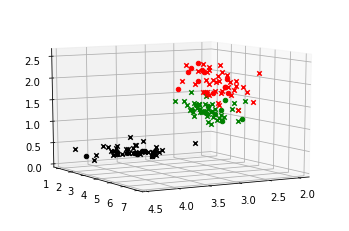

In [17]:
# Use 2 dimension data for testing code
simple_train = [data[1:] for data in train]
simple_test  = [data[1:] for data in test]

plot_colors = ['green', 'black', 'red']
plot_train_symbols = 'x'
plot_test_symbols  = 'o'
plot_labels = ['0', '1', '2']
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
for data in simple_train:
    axes.scatter(data[0], data[1], data[2], c=plot_colors[data[-1]], marker=plot_train_symbols)

for data in simple_test:
    axes.scatter(data[0], data[1], data[2], c=plot_colors[data[-1]], marker=plot_test_symbols)

# rotate the axes and update
axes.view_init(10, 60)

In [18]:
K = ceil(sqrt(len(train)))
if K % 2 == 0:
    K += 1
# K = 3
print(f"K = {K}") 

preds = KNN(K, train, test, False)
groundtruth = [data[-1] for data in test]
acc = accuracy_metric(groundtruth, preds)
print(f"Accuracy: {acc}")

K = 11
Accuracy: 93.33333333333333
